In [1]:
# Read summary of Pb SO-CI results from file "Pb_SOCI_results.xlsx"

import sys, os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, r'../../atomic_SOC')
import chem_subs as chem

In [2]:
def read_datafile(fname):
    # read data from CSV or Excel file
    froot = os.path.split(fname)[-1]
    if 'xlsx' in fname:
        xl = pd.ExcelFile(fname)
        if len(xl.sheet_names) > 1:
            print('Available worksheets:', xl.sheet_names)
            sheet = input('\tchoose a worksheet: ')
        else:
            sheet = xl.sheet_names[0]
        print(f'Reading worksheet "{sheet}" from Excel file {froot}')
        df = xl.parse(sheet, header=None)
    return sheet, df

In [3]:
datadir = r'C:\Users\irikura\OneDrive - NIST\Karl\atomic_SOC\MSS'
datafile = 'Pb_SOCI_results.xlsx'
fdata = os.sep.join([datadir, datafile])
# Data selection flags
use_PP = True  # use results from pseudopotential calculations
use_AE = True  # use results from all-electron calculations 

In [4]:
print(f'Reading SO-CI data from {fdata}')
xl = pd.ExcelFile(fdata)
df_letters = xl.parse('letter codes', skiprows=1)
ncalc = len(df_letters)
print(f'There are results for {ncalc} calculations')
re_num = re.compile(r'\d\d+')
# Check that filenames are consistent with other descriptors
nbad = 0
iPPl = []  # rows with PP basis set
iAEl = []  # rows with AE basis set
for irow, row in df_letters.iterrows():
    fn = row['Filename']
    # basis set
    bas = row['Basis set']
    bad = False
    if 'pp' in bas:
        iPPl.append(irow)
        if bas not in fn:
            bad = True
    else:
        # all-electron calculation
        iAEl.append(irow) 
        if 'pp' in fn:
            bad = True
        else:
            # remove suffix
            for suf in ['dk3', 'dk', 'x2c']:
                bas = bas.replace(suf, '')
            if bas not in fn:
                bad = True
    if bad:
        print(f'*** basis = {bas} for filename = {fn} looks wrong ***')
        nbad += 1
        continue  # don't check this filename further
    # multi-digit numbers in filename should be 3P weight or active space
    numl = re_num.findall(fn)
    if len(numl):
        wt = str(row['3P wt in CASSCF'])
        acts = row['Active space'].replace(')', '').replace('(', '').replace('/', '')
        for num in numl:
            if (wt != num) and (acts != num):
                print(f'*** filname {fn} does not match active space {row["Active space"]} or 3P weight {wt}')
                nbad += 1
if nbad:
    print(f'*** There are {nbad} questionable filenames ***')
else:
    print('Filenames look fine')

Reading SO-CI data from C:\Users\irikura\OneDrive - NIST\Karl\atomic_SOC\MSS\Pb_SOCI_results.xlsx
There are results for 34 calculations
Filenames look fine


In [5]:
# Apply restrictions (PP, AE)
if not use_PP:
    df_letters = df_letters.drop(iPPl)
    print(f'*** dropping {len(iPPl)} PP calculations')
if not use_AE:
    df_letters = df_letters.drop(iAEl) 
    print(f'*** dropping {len(iAEl)} AE calculations')

In [6]:
df_letters.head()

,Calc,Terms,3P wt in CASSCF,Basis set,Active space,Raw Eso,Filename,eq. (2),Comments
0,A,"3(P,D,P,S) + 1(D,S,P,D,S)",1,actzpp,(4/7),-10883.89,pb_3PDPS1DSPDS_actzpp.pro,-11509.75,"err(J=1,2) = -598, -444"
1,B,"3(P,D,P,S) + 1(D,S,P,D,S)",1,acqzpp,(4/7),-11102.42,pb_3PDPS1DSPDS_acqzpp.pro,-11507.83,"err(J=1,2) = -379, -231. Levels above 50000 c..."
2,D,"3(P,D,P,S) + 1(D,S,P,D,S)",1,ac5zpp,(4/7),-11166.40,pb_3PDPS1DSPDS_ac5zpp.pro,-11512.28,"(cf. M) (48.7 hrs) err(J=1,2) = -326, -174; er..."
3,F,3P + 1D,1,actzdk3,(4/4),-11440.81,pb_3P1D_actz.pro,-11550.90,"err(J=1,2) = -2099, -1622 (and J=2 is led by 1..."
4,G,3P + 1D,1,acqzdk3,(4/4),-11725.99,pb_3P1D_acqz.pro,-11568.02,"(1 hour) err(J=1,2) = -1956, -1452 (1D as abov..."


In [7]:
# Read all the data pages
dfd = {}  # key = letter code, value = DataFrame
for lett in df_letters.Calc:
    dfd[lett] = xl.parse(lett)

In [8]:
incols = df_letters.columns
dfout = df_letters[incols[:7]].copy()

### Compute energy of 3P term using exptl energy levels

In [9]:
Esol = []
nround = 1  # number of decimals (cm-1)
tol = 0.1 ** nround  # cm-1
nbad = 0
for icalc, row in df_letters.iterrows():
    lett = row['Calc']
    df = dfd[lett]
    wcol = '(1)3P'
    if wcol not in df.columns:
        wcol = '3P'
    wts = df[wcol].values
    levs = df['Expt/cm-1'].values
    Eso = - np.dot(wts, levs) / wts.sum()
    eq2 = df_letters.at[icalc, "eq. (2)"]  # value from the summary spreadsheet
    if abs(Eso - eq2) > tol:
        # print warning
        print(f'*** For calc {lett:<3s}, Eso = {Eso:.1f} is different from ealier value {eq2:.1f} ***')
        nbad += 1
    Esol.append(Eso)
dfout['Eso'] = np.round(Esol, nround)
if nbad:
    print(f'*** Current evaluation of eq. (2) differs from earlier in {nbad} cases ***')
else:
    print('Current evaluation of eq. (2) agrees with earlier values')

Current evaluation of eq. (2) agrees with earlier values


### Compute weighted unsigned error of 3P-derived level energies

In [10]:
werrl = []
for icalc, lett in enumerate(dfd.keys()):
    df = dfd[lett]
    wcol = '(1)3P'
    if wcol not in df.columns:
        wcol = '3P'
    wts = df[wcol].values
    uerr = np.abs(df['err'].values)
    werr = np.dot(wts, uerr) / wts.sum()
    werrl.append(werr)
dfout['wtd uerr'] = np.round(werrl, nround)

In [11]:
# Discard calculations with excessive error in 3P level energies 
max_uerr = 1000.  # only use calculations with smaller values of the weighted, unsigned error in 3P levels
nbig = len(dfout[dfout['wtd uerr'] > max_uerr])
if nbig:
    print(f'Discarding {nbig} calculations because their energy errors > {max_uerr} cm-1')
    dfout = dfout[dfout['wtd uerr'] <= max_uerr]

Discarding 18 calculations because their energy errors > 1000.0 cm-1


In [12]:
# Show all results in use, sorted by increasing weighted, unsigned error in 3P level energies
print(f'{len(dfout)} calculations are being considered (sorted by energy error):')
dfout.sort_values('wtd uerr')

16 calculations are being considered (sorted by energy error):


,Calc,Terms,3P wt in CASSCF,Basis set,Active space,Raw Eso,Filename,Eso,wtd uerr
21,X,"3(P,D,P,S) + 1(D,S,P,D,S)",1,tac5zpp,(4/7),-11177.12,pb_3PDPS1DSPDS_tac5zpp.pro,-11503.3,339.9
10,M,"3(P,D,P,S) + 1(D,S,P,D,S)",1,dac5zpp,(4/7),-11176.85,pb_3PDPS1DSPDS_dac5zpp.pro,-11503.5,340.5
2,D,"3(P,D,P,S) + 1(D,S,P,D,S)",1,ac5zpp,(4/7),-11166.40,pb_3PDPS1DSPDS_ac5zpp.pro,-11512.3,361.3
32,AI,"3(P,D,P,S) + 1(D,S,P,D,S)",1,dac5zpp,(4/8),-11147.50,pb_3PDPS1DSPDS_dac5zpp_48.pro,-11495.0,361.6
13,P,"3(P,D,P,S) + 1(D,S,P,D,S)",1,tacqzpp,(4/7),-11116.38,pb_3PDPS1DSPDS_tacqzpp.pro,-11495.9,392.9
11,N,"3(P,D,P,S) + 1(D,S,P,D,S)",1,dacqzpp,(4/7),-11116.10,pb_3PDPS1DSPDS_dacqzpp.pro,-11496.2,393.5
1,B,"3(P,D,P,S) + 1(D,S,P,D,S)",1,acqzpp,(4/7),-11102.42,pb_3PDPS1DSPDS_acqzpp.pro,-11507.8,421.0
14,Q,"3(P,D,P,S,P) + 1(D,S,P,D,S)",1,tacqzpp,(4/7),-11083.07,pb_3PDPSP1DSPDS_tacqzpp.pro,-11531.0,465.9
31,AH,"3(P,D,P,S) + 1(D,S,P,D,S)",1,dac5zpp,(2/6),-10914.20,pb_3PDPS1DSPDS_dac5zpp_26.pro,-11457.6,555.8
23,Z,"3(P,D,P,S) + 1(D,S,P,D,S)",1,usp-dacqzpp,(2/6),-10880.07,pb_3PDPS1DSPDS_usp-dacqzpp_26.pro,-11453.8,585.8


Uncertainty as weighted unsigned error in computed 3P level energies


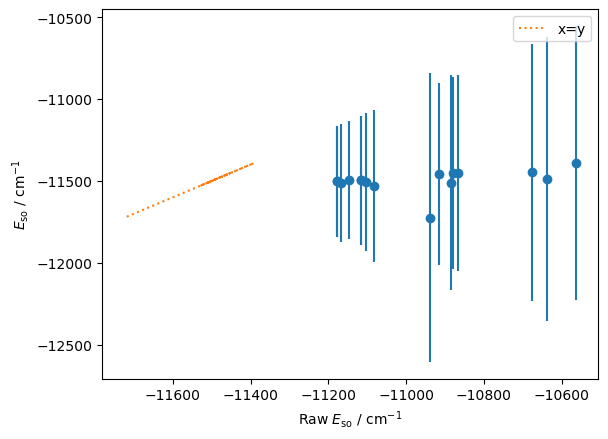

In [13]:
# Choose values for uncertainties
print('Uncertainty as weighted unsigned error in computed 3P level energies')
yunc = dfout['wtd uerr']
plt.errorbar(dfout['Raw Eso'], dfout['Eso'], yerr=yunc, fmt='o')
plt.ylabel(r'$E_\mathrm{so}$ / cm$^{-1}$')
plt.xlabel(r'Raw $E_\mathrm{so}$ / cm$^{-1}$')
# show y=x line
plt.plot(dfout['Eso'], dfout['Eso'], ls=':', label='x=y')
plt.legend()
plt.show()

In [14]:
print('Unweighted stats for raw and eq. (2) values of Eso:')
xraw = dfout["Raw Eso"].values
xeq2 = dfout['Eso'].values
mraw = xraw.mean()
meq2 = xeq2.mean()
dfu = pd.DataFrame({'mean': np.round([mraw, meq2], nround), 
                   'stds': np.round([xraw.std(ddof=1), xeq2.std(ddof=1)]),
                   'range': np.round([np.ptp(xraw), np.ptp(xeq2)], nround)},
                   index=['raw', 'eq. (2)'])
display(dfu)
print(f'    Means differ by {mraw - meq2:.1f}')

Unweighted stats for raw and eq. (2) values of Eso:


,mean,stds,range
raw,-10965.4,203.0,613.6
eq. (2),-11498.0,69.0,331.9


    Means differ by 532.5


In [15]:
print(f'Number of calculations considered = {len(dfout)}')
for p in [-1, -2, -0.5]:
    print(f'Weighted stats for raw and eq. (2) values of Eso, weights = yunc**{p}:')
    mraw, uraw = chem.weighted_mean(xraw, yunc**p)
    meq2, ueq2 = chem.weighted_mean(xeq2, yunc**p)
    dfw = pd.DataFrame({'wmean': np.round([mraw, meq2], nround), 
                       'wstds': np.round([uraw, ueq2], nround)},
                       index=['raw', 'eq. (2)'])
    #dfw.loc['diff'] = [xraw - xeq2, 0]
    display(dfw)
    print(f'    Means differ by {mraw - meq2:.1f}')

Number of calculations considered = 16
Weighted stats for raw and eq. (2) values of Eso, weights = yunc**-1:


,wmean,wstds
raw,-11022.8,42.2
eq. (2),-11497.7,10.6


    Means differ by 474.9
Weighted stats for raw and eq. (2) values of Eso, weights = yunc**-2:


,wmean,wstds
raw,-11068.0,32.6
eq. (2),-11498.6,6.5


    Means differ by 430.6
Weighted stats for raw and eq. (2) values of Eso, weights = yunc**-0.5:


,wmean,wstds
raw,-10995.3,46.9
eq. (2),-11497.7,13.6


    Means differ by 502.3


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [16]:
1/0  # stop here by default

ZeroDivisionError: division by zero

### Find mean values of <sup>3</sup>P coefficients in levels

In [17]:
# Get the coefficients from each Molpro file
df3Pu = None
Ecol = 'Expt/cm-1' 
for irow, row in dfout.sort_values('wtd uerr').iterrows():
    lett = row.Calc
    #print(lett)
    df = dfd[lett]
    wcol = '(1)3P'
    if wcol not in df.columns:
        wcol = '3P'
    #display(df)
    if df3Pu is None:
        df3Pu = df[[Ecol, 'J', wcol]].copy().rename(columns={wcol: lett})
    else:
        # add a new column
        df3Pu[lett] = np.nan
        for wt, expt, J in zip(df[wcol], df[Ecol], df.J):
            dfe = df3Pu[df3Pu[Ecol].round(1) == round(expt, 1)]
            if len(dfe):
                df3Pu.at[dfe.index[0], lett] = wt
            else:
                # must add another level (row) to df3P
                #print(f'add a row for expt = {expt}')
                inew = len(df3Pu)
                df3Pu.at[inew, Ecol] = expt
                df3Pu.at[inew, 'J'] = J
                df3Pu.at[inew, lett] = wt
print('Coefficients from the selected Molpro files:')
display(df3Pu)
# The coefficients are the same input for the weighted statistics
df3Pu.insert(2, 'stds', 0.)
df3Pu.insert(2, 'mean', 0.)
df3Pw = df3Pu.copy()

Coefficients from the selected Molpro files:


,Expt/cm-1,J,X,M,D,AI,P,N,B,Q,AH,Z,Y,A,W,V,O,AJ
0,0.0000,0.0,0.862867,0.862865,0.862793,0.863061,0.863698,0.863692,0.863598,0.863485,0.869459,0.869708,0.869848,0.866034,0.871309,0.871391,0.865942,0.859825
1,7819.2626,1.0,2.991552,2.991532,2.990781,2.991189,2.991475,2.991453,2.990451,2.988278,2.992557,2.992456,2.992467,2.986247,2.987137,2.996242,2.987426,2.969233
2,10650.3271,2.0,2.957911,2.957872,2.956261,2.967098,2.962135,2.962058,2.959931,2.956681,2.970828,2.973921,2.975377,2.980399,2.989272,2.998361,2.991704,2.933610
3,21457.7982,2.0,2.033006,2.033025,2.033870,2.023436,2.028756,2.028811,2.029924,2.031026,2.021131,2.017979,2.016538,2.005509,2.000017,1.991183,1.995180,2.036196
4,29466.8303,0.0,0.132233,0.132227,0.131995,0.131841,0.131388,0.131385,0.131081,0.130240,0.125880,0.125605,0.125472,0.127384,0.127847,0.127815,0.128174,0.129289
5,44400.8898,0.0,0.003362,0.003367,0.003565,0.003498,0.003378,0.003384,0.003643,0.004335,0.003221,0.003246,0.003241,0.004478,0.000844,0.000794,0.004065,0.007825
6,44674.9859,1.0,0.002737,0.002744,0.002982,0.002844,0.002778,0.002785,0.003104,0.003875,0.002377,0.002426,0.002422,0.004531,0.004151,0.002311,0.003997,0.009993
7,44809.3636,2.0,0.001170,0.001173,0.001327,0.001233,0.001191,0.001195,0.001405,0.001788,0.001039,0.001062,0.001061,0.002523,0.010468,0.010224,0.002167,0.007636
8,51320.5981,1.0,0.003521,0.003529,0.003854,0.003735,0.003541,0.003551,0.003985,0.005130,0.003082,0.003114,0.003108,0.005799,0.005855,NaN,0.005859,0.017269
9,51944.1059,2.0,0.001403,0.001407,0.001539,0.001491,0.001422,0.001426,0.001598,0.002113,0.001148,0.001173,0.001171,0.002313,0.000243,0.000232,0.002373,0.006578


In [18]:
# Unweighted statistics
cols = df3Pu.columns[4:]  # just the data rows
for irow, row in df3Pu.iterrows():
    a = row[cols].values.copy()
    a = a[~np.isnan(a)]
    m = np.mean(a)  # there should be at least one value
    if len(a) == 1:
        # use the value as the stdev
        s = m
    elif len(a) == 2:
        # use the difference
        s = np.ptp(a)
    else:
        # use sample stdev
        s = np.std(a, ddof=1)
    df3Pu.at[irow, 'mean'] = m
    df3Pu.at[irow, 'stds'] = s

In [19]:
# Weighted statistics
p = -1  # use this power of 'yunc' as the weights
print(f'Weighted stats using yunc**{p}')
cols = df3Pw.columns[4:]  # just the data rows
for irow, row in df3Pw.iterrows():
    a = row[cols].values.copy()  # coefficents for this level, across Molpro files
    idx = np.nonzero(~np.isnan(a))
    winv = yunc.values[idx]
    a = a[idx]
    m, s = chem.weighted_mean(a, winv**p)
    # 's' is -1 when there aren't enough data
    if s < 0:
        s = m
    df3Pw.at[irow, 'mean'] = m
    df3Pw.at[irow, 'stds'] = s

Weighted stats using yunc**-1


In [20]:
# Select weighted or unweighted
weighted = True
if weighted:
    df3P = df3Pw.copy()
    print('Using weighted stats to determine mean coeffs')
    wtstr = 'weighted'
else:
    df3P = df3Pu.copy()
    print('Using UNweighted stats to determine mean coeffs')
    wtstr = 'unweighted'

Using weighted stats to determine mean coeffs


In [21]:
# Enforce normalization by scaling both mean and stds
targsum = 9.  # total multiplicity for 3P
scale = targsum / df3P['mean'].values.sum()
df3P['mean'] *= scale
df3P['stds'] *= scale
print('Mean and stds are scaled by', scale)
# Retain only the main values
#df3P = df3P[df3P.columns[:4]]

Mean and stds are scaled by 0.9998391689988104


In [22]:
Eso = -np.dot(df3P['mean'], df3P[Ecol]) / targsum
print(f'Average ({wtstr}) values of 3P coefficients (imply Eso = {Eso:.1f} cm-1)')
df3P

Average (weighted) values of 3P coefficients (imply Eso = -11500.4 cm-1)


,Expt/cm-1,J,mean,stds,X,M,D,AI,P,N,B,Q,AH,Z,Y,A,W,V,O,AJ
0,0.0000,0.0,0.865308,0.000840,0.862867,0.862865,0.862793,0.863061,0.863698,0.863692,0.863598,0.863485,0.869459,0.869708,0.869848,0.866034,0.871309,0.871391,0.865942,0.859825
1,7819.2626,1.0,2.989438,0.000973,2.991552,2.991532,2.990781,2.991189,2.991475,2.991453,2.990451,2.988278,2.992557,2.992456,2.992467,2.986247,2.987137,2.996242,2.987426,2.969233
2,10650.3271,2.0,2.968437,0.003783,2.957911,2.957872,2.956261,2.967098,2.962135,2.962058,2.959931,2.956681,2.970828,2.973921,2.975377,2.980399,2.989272,2.998361,2.991704,2.933610
3,21457.7982,2.0,2.019943,0.003803,2.033006,2.033025,2.033870,2.023436,2.028756,2.028811,2.029924,2.031026,2.021131,2.017979,2.016538,2.005509,2.000017,1.991183,1.995180,2.036196
4,29466.8303,0.0,0.129559,0.000656,0.132233,0.132227,0.131995,0.131841,0.131388,0.131385,0.131081,0.130240,0.125880,0.125605,0.125472,0.127384,0.127847,0.127815,0.128174,0.129289
5,44400.8898,0.0,0.003458,0.000280,0.003362,0.003367,0.003565,0.003498,0.003378,0.003384,0.003643,0.004335,0.003221,0.003246,0.003241,0.004478,0.000844,0.000794,0.004065,0.007825
6,44674.9859,1.0,0.003326,0.000300,0.002737,0.002744,0.002982,0.002844,0.002778,0.002785,0.003104,0.003875,0.002377,0.002426,0.002422,0.004531,0.004151,0.002311,0.003997,0.009993
7,44809.3636,2.0,0.002602,0.000713,0.001170,0.001173,0.001327,0.001233,0.001191,0.001195,0.001405,0.001788,0.001039,0.001062,0.001061,0.002523,0.010468,0.010224,0.002167,0.007636
8,51320.5981,1.0,0.004624,0.000571,0.003521,0.003529,0.003854,0.003735,0.003541,0.003551,0.003985,0.005130,0.003082,0.003114,0.003108,0.005799,0.005855,NaN,0.005859,0.017269
9,51944.1059,2.0,0.001632,0.000232,0.001403,0.001407,0.001539,0.001491,0.001422,0.001426,0.001598,0.002113,0.001148,0.001173,0.001171,0.002313,0.000243,0.000232,0.002373,0.006578


### Monte Carlo propagation of constrained uncertainties

In [23]:
# Assume an independent beta distribution for each coefficient
# But enforce normalization of the sum of the coefficients

# must normalize each mean value to 1 to use a beta distribution
# the weight in a level cannot exceed 2J+1 
Evals = df3P[Ecol].values
jvals = df3P.J.values
gvals = 2 * jvals + 1
m1 = df3P['mean'].values / gvals
s1 = df3P['stds'].values / gvals
expt = df3P[Ecol].values

In [24]:
def multi_sample(ntrial, normtol=0.001):
    # Use globals to generate a set of 3P coeffients, compute E_so and return it
    # Require normalization to 'targsum' (=9.0) within tolerance 'normtol' 
    # sample each coefficient from its beta distribution
    nvar = len(m1)
    cmat = np.zeros((ntrial, nvar))
    for i in range(nvar):
        cmat[:, i] = chem.get_beta(m1[i], s1[i], nsample=ntrial) * gvals[i]
    csum = cmat.sum(axis=1)
    idx = np.nonzero((csum >= targsum) & ((csum - targsum) <= normtol))
    cmat = cmat[idx, :][0]
    # scale downward to hit 'targsum'
    cmat = targsum * (cmat / cmat.sum(axis=1)[:, None])
    # compute E_so
    esol = -np.dot(cmat, Evals) / targsum
    return esol

In [25]:
def one_sample(normtol=0.001, maxiter=1000):
    # Use globals to generate a set of 3P coeffients, compute E_so and return it
    # Require normalization to 'targsum' (=9.0) within tolerance 'normtol' 
    norm = -np.inf
    itry = 0
    while ((norm < targsum) or ((norm - targsum) > normtol)) and (itry < maxiter):
        # sample each coefficient from its beta distribution
        coeffs = np.zeros_like(m1)
        for i in range(len(m1)):
            c = chem.get_beta(m1[i], s1[i], nsample=1)
            coeff = c * gvals[i]
            coeffs[i] = coeff[0]
        norm = coeffs.sum()
        itry += 1
    # norm is slightly larger than targsum
    # scale all values downward to get correct normalization
    #   (don't scale upward, to avoid violating the 2*J+1 upper limits)
    if itry >= maxiter:
        # failure
        return None, itry
    coeffs *= targsum / norm
    # compute E_so
    Eso = -np.dot(coeffs, Evals) / targsum
    return float(Eso), itry

In [26]:
Nsamples = 10 * 1000 * 1000  # number of samples to draw
ntrials = 0  # total number of trials (including rejects)
esol = []

In [27]:
one_at_a_time = False  # set False for better performance

In [28]:
if one_at_a_time:
    for i in range(Nsamples):
        Eso, ntry = one_sample()
        if Eso is not None:
            # successful
            esol.append(Eso)
        if ((i % 5000) == 0) and (i > 0):
            print(f'{i}...', end='')
        ntrials += ntry
else:
    ngood = 0
    aratio = None  # acceptance ratio
    notcrazy = 10 * 1000 * 1000
    while ngood < Nsamples:
        ntry = Nsamples - ngood
        if aratio is not None:
            # apply acceptance ratio but don't go crazy
            ntry = min(int(ntry / aratio), notcrazy)
        evec = multi_sample(ntry)
        if aratio is None:
            # get a value of the acceptance ratio
            aratio = len(evec) / ntry
            print(f'Adjusting for acceptance ratio = {aratio:.4f}')
        esol.extend(evec)
        ngood += len(evec)
        ntrials += ntry
        print(f'{ngood}...', end='')
print('done')

Adjusting for acceptance ratio = 0.0701
700969...1401192...2101303...2800726...3502352...4201993...4900698...5599696...6300056...7000121...7699425...8398503...9096975...9797236...9999765...10000006...done


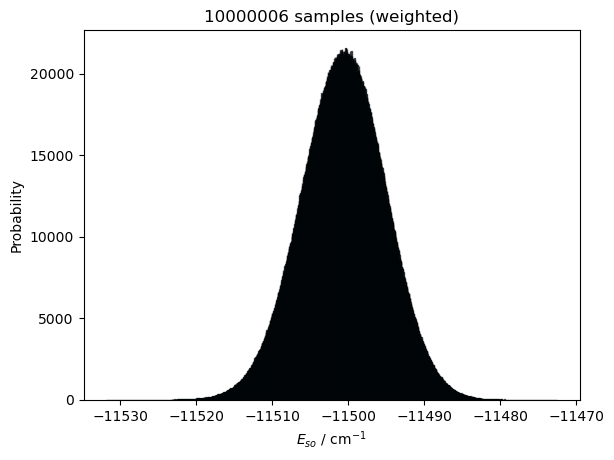

In [29]:
nbin = 2000
h = plt.hist(esol, bins=nbin, edgecolor='black', alpha=0.7, density=False, stacked=False)
plt.title(f'{len(esol)} samples ({wtstr})')
plt.xlabel(r'$E_{so}$ / cm$^{-1}$')
plt.ylabel('Probability')
#plt.grid(True)
plt.show()

In [31]:
acc = len(esol) / ntrials
print(f'Coefficients from {wtstr} averaging')
print(f'Acceptance ratio = {acc:.3f}')
m = np.mean(esol)
s = np.std(esol, ddof=1)
print(f'Mean Eso = {m:.1f} cm-1 with stdev = {s:.1f}')
counts = h[0]
xgrid = h[1]
nbin = len(counts)
print(f'Confidence intervals (from {len(esol)} samples in {nbin} bins):')
for conf in [50, 67, 95, 99, 99.9]:
    [ilo, ihi] = chem.confinterval(h[0], conf)
    xlo = xgrid[ilo]
    xhi = xgrid[ihi]
    print(f'{conf}%  :  [{xlo:.1f}, {xhi:.1f}] or [{xlo-m:.1f}, +{xhi-m:.1f}]')

Coefficients from weighted averaging
Acceptance ratio = 0.070
Mean Eso = -11500.7 cm-1 with stdev = 5.6
Confidence intervals (from 10000006 samples in 2000 bins):
50%  :  [-11504.7, -11497.2] or [-4.0, +3.4]
67%  :  [-11506.3, -11495.5] or [-5.6, +5.2]
95%  :  [-11511.7, -11489.9] or [-11.0, +10.7]
99%  :  [-11515.2, -11486.6] or [-14.5, +14.1]
99.9%  :  [-11519.5, -11482.9] or [-18.8, +17.8]
